In [ ]:
!pip install nltk==3.5
!pip install unidecode
!pip install vaderSentiment
!pip install spacy

In [2]:
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords

import string
from unidecode import unidecode
from collections import Counter

import spacy
from spacy import displacy
import en_core_web_sm

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Loading the dataset #


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
arquivo1 = "/content/drive/MyDrive/TrabalhoFinalNLP/hashtag_donaldtrump.csv"
arquivo2 = "/content/drive/MyDrive/TrabalhoFinalNLP/hashtag_joebiden.csv"

# Redução do tamanho do dataset #

    A ideia era utilizar todo o dataset para realizar a análise. 
    Entretanto foi inviável devido ao tempo excessivo para processar as entidades e os recursos fornecidos pelo Colab.

    Desta forma, foi utilizado apenas os primeiros cem mil registros de cada arquivo.

In [5]:
dataset1 = pd.read_csv(arquivo1,lineterminator='\n')
dataset1 = dataset1.head(100000)
dataset2 = pd.read_csv(arquivo2,lineterminator='\n')
dataset2 = dataset2.head(100000)

In [6]:
dataset = dataset1.append(dataset2)
dataset = dataset.reset_index(drop=True)

# Preprocessamento #

    Nesta etapa será realizado um pré-processamento dos tweets com as seguintes operações:
    • Tokenização;
    • Conversão de todo o texto para minúsculas;
    • Remoção de stopwords em inglês;
    • Remoção de números;
    • Remoção de pontuações;
    • Remoção de acentos;
    • Remoção de termo em específico (‘https’)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def pre_processamento_texto(corpus):
  corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus)
  corpus_alt = [t.lower() for t in corpus_alt]
  stops = stopwords.words('english')
  corpus_alt = [t for t in corpus_alt if t not in stops]
  corpus_alt = [re.sub(r"\d", '', t) for t in corpus_alt]
  corpus_alt = [t for t in corpus_alt if t not in string.punctuation]
  corpus_alt = [unidecode(t) for t in corpus_alt]
  corpus_alt = [t for t in corpus_alt if t != 'https']
  corpus_alt_str = " ".join(corpus_alt)

  return corpus_alt_str

In [9]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


In [10]:
dataset["texto_sem_stopwords"] = dataset["tweet"].progress_apply(lambda x: pre_processamento_texto(x))

  0%|          | 0/200000 [00:00<?, ?it/s]

# Classificação de sentimento dos tweets utilizando Vader #

    Nesta etapa, os tweets pré-processados foram classificados utilizando a ferramenta Vader. Para tal, foi criada uma coluna no dataframe (‘sentiment_compound’) que recebeu o score compound dado pelo Vader. Em seguida, foi criada a coluna (‘sentiment’) baseada na classificação compound do Vader; positivo, se compound >= 0.05, negativo, se compound <= -0.05 e neutro dentro do intervalo.

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [12]:
analyzer = SentimentIntensityAnalyzer()

In [13]:
%%time
dataset["sentiment_compound"] = [analyzer.polarity_scores(doc)['compound'] for doc in dataset['texto_sem_stopwords']]

CPU times: user 29.2 s, sys: 49.2 ms, total: 29.2 s
Wall time: 29.3 s


In [14]:
dataset["sentiment"] = ["positive" if d >= 0.05 else "negative" if d <= -0.05 else "neutral" for d in dataset["sentiment_compound"]]

# Identificação de Entidades NER #

    Para identificação das entidades foi utilizado o modelo en_core_web_sm da biblioteca spacy. Foram demonstrados os tipos de entidades e as principais entidades encontradas nos tweets classificados como positivos e negativos, separadamente.

In [15]:
modelo = en_core_web_sm.load()

In [16]:
# Este método recebe um dataset de tweets e retorna dois documentos:
# docs -> Dicionário contento os tweets do dataset com identificação das entidades;
# entidades -> Dicionário contendo as entidades encontradas nos documentos.

def get_entidades(d):
  d = d.reset_index()
  #docs = {id: modelo(d["tweet"][id]) for id in range(len(d['tweet']))}
  docs = d['tweet'].progress_apply(lambda x: modelo(x))
  docs = {id: docs[id] for id in range(len(docs))}
  entidades = {id:set(map(str,docs[id].ents)) for id in range(len(d['tweet']))}

  return entidades, docs

In [17]:
# Este método retorna um dicionário contendo a contagem de cada tipo de entidade encontrada no dataset
# e uma lista contendo as top 10 entidades mencionadas e quantas vezes foram mencionadas.

def analisa_entidades(entidades, docs):
  ents = [n.ents for n in docs.values()]

  tipo_ents = []
  for item in ents:
    for i in item:
      tipo_ents.append(i.label_)
  
  todas_entidades = []

  for k in entidades.keys():
    todas_entidades.extend(entidades[k])

  todas_entidades = Counter(todas_entidades)  

  return Counter(tipo_ents), todas_entidades.most_common(10)

# Entidades mencionadas nos tweets classificados como positivos #

In [19]:
df_positivas = dataset.loc[dataset['sentiment'] == 'positive']

entidades_pos, tweets_pos = get_entidades(df_positivas)
tipo_ents_pos, most_common_ents_pos = analisa_entidades(entidades_pos, tweets_pos)

  0%|          | 0/66209 [00:00<?, ?it/s]

In [20]:
for i in sorted(tipo_ents_pos, key = tipo_ents_pos.get, reverse=True):
    print(i, tipo_ents_pos[i])

PERSON 94400
MONEY 51888
ORG 35587
GPE 21150
DATE 13844
CARDINAL 12487
NORP 11237
PERCENT 4161
PRODUCT 3988
LOC 2900
TIME 2203
WORK_OF_ART 2085
ORDINAL 1502
FAC 1150
QUANTITY 501
LAW 258
EVENT 205
LANGUAGE 52


In [21]:
most_common_ents_pos

[('Trump', 23259),
 ('Biden', 13555),
 ('JoeBiden', 9184),
 ('America', 2114),
 ('trump', 2101),
 ('DonaldTrump', 1996),
 ('US', 1564),
 ('#trump', 1556),
 ('#', 1517),
 ('Democrats', 1383)]

# Entidades mencionadas nos tweets classificados como negativos #

In [22]:
df_negativas = dataset.loc[dataset['sentiment'] == 'negative']

entidades_neg, tweets_neg = get_entidades(df_negativas)
tipo_ents_neg, most_common_ents_neg = analisa_entidades(entidades_neg, tweets_neg)

  0%|          | 0/64683 [00:00<?, ?it/s]

In [23]:
for i in sorted(tipo_ents_neg, key = tipo_ents_neg.get, reverse=True):
    print(i, tipo_ents_neg[i])

PERSON 100576
MONEY 51081
ORG 38535
GPE 19685
CARDINAL 13983
NORP 13104
DATE 11455
PRODUCT 4744
LOC 2933
WORK_OF_ART 2199
TIME 1956
ORDINAL 1566
PERCENT 1168
FAC 1052
QUANTITY 487
EVENT 458
LAW 299
LANGUAGE 51


In [24]:
most_common_ents_neg

[('Trump', 27245),
 ('Biden', 12606),
 ('JoeBiden', 7162),
 ('trump', 2556),
 ('DonaldTrump', 2131),
 ('US', 2051),
 ('Americans', 1950),
 ('America', 1935),
 ('#', 1648),
 ('#trump', 1475)]

# Gráficos #

In [25]:
# Define o tamanho da nuvem de palavras para entidades

max_words_ents = 25

In [26]:
def get_nuvem_entidades(entidades):

  todas_entidades = []

  for k in entidades.keys():
    todas_entidades.extend(entidades[k])

  return " ".join(todas_entidades)

In [27]:
def cria_nuvem_palavras(palavras, max_words=500):
  nuvem_palavras = WordCloud(max_words=max_words).generate(palavras)

  plt.figure(1, figsize=(15,15))
  plt.imshow(nuvem_palavras)
  plt.show()

# Principais entidades mencionadas nos tweets positivos #

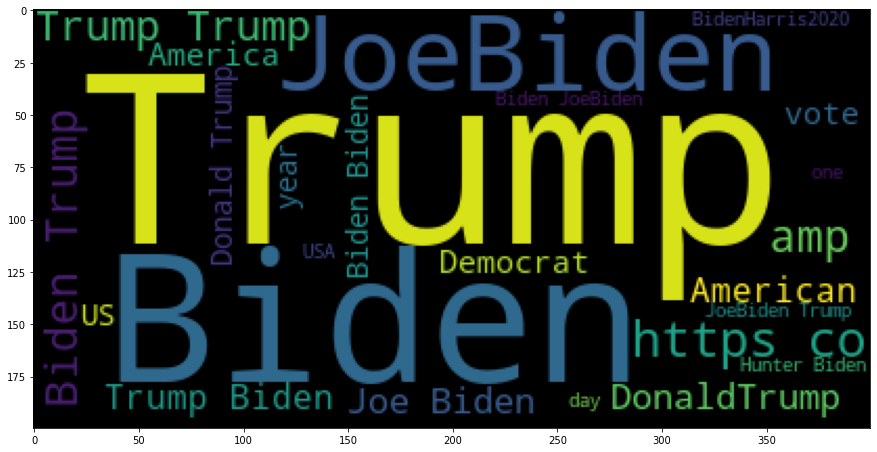

In [28]:
nuv_ents_pos = get_nuvem_entidades(entidades_pos)
cria_nuvem_palavras(nuv_ents_pos, max_words=max_words_ents)

# Principais entidades mencionadas nos tweets negativos #

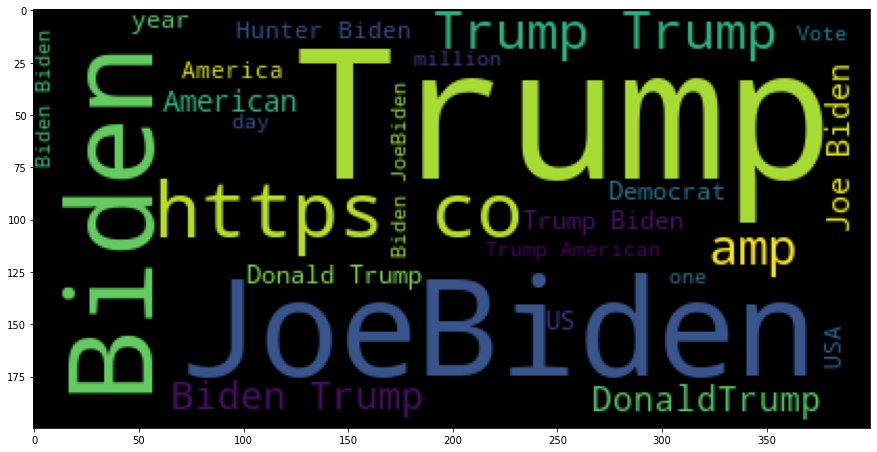

In [30]:
nuv_ents_neg = get_nuvem_entidades(entidades_neg)
cria_nuvem_palavras(nuv_ents_neg, max_words=max_words_ents)

# Análise das palavras em geral encontradas nos tweets #

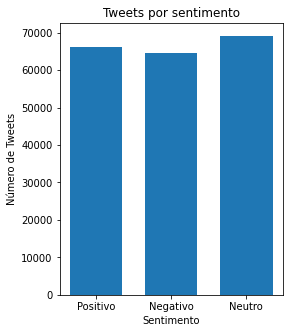

In [31]:
# Tweets por sentimento

plot = {'Positivo':len(dataset.loc[dataset.sentiment=='positive']),
        'Negativo':len(dataset.loc[dataset.sentiment=='negative']),
        'Neutro':len(dataset.loc[dataset.sentiment=='neutral'])}

plt.figure(figsize = (4,5))

plt.bar(list(plot.keys()), list(plot.values()), width=0.7)

plt.title("Tweets por sentimento")
plt.ylabel("Número de Tweets")
plt.xlabel("Sentimento")
plt.show()

# Top 500 palavras encontradas considerando todos os tweets #

In [32]:
palavras = " ".join(dataset['texto_sem_stopwords'])

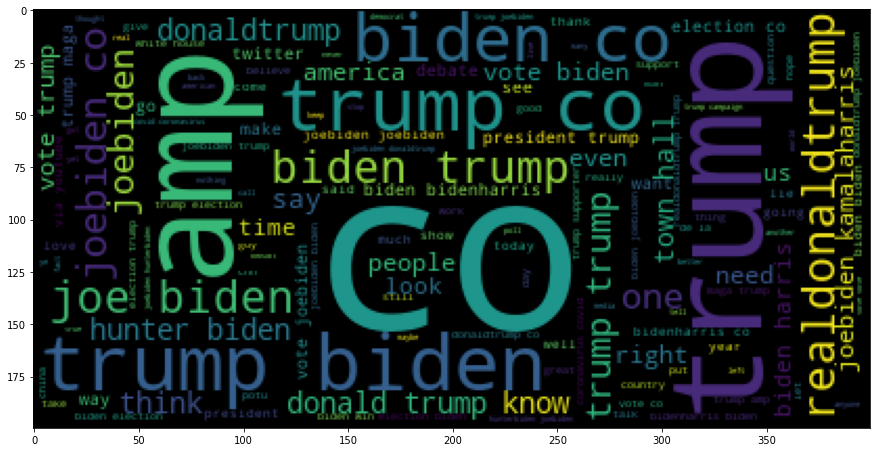

In [34]:
cria_nuvem_palavras(palavras)

# Top 500 palavras nos tweets positivos #

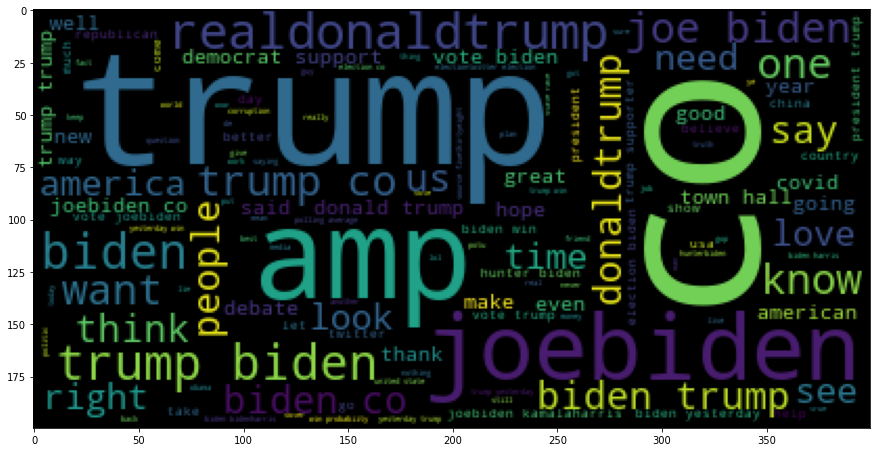

In [35]:
df_positivas = dataset.loc[dataset['sentiment'] == 'positive']
positivas = " ".join(df_positivas['texto_sem_stopwords'])
cria_nuvem_palavras(positivas)

# Top 500 palavras nos tweets negativos #

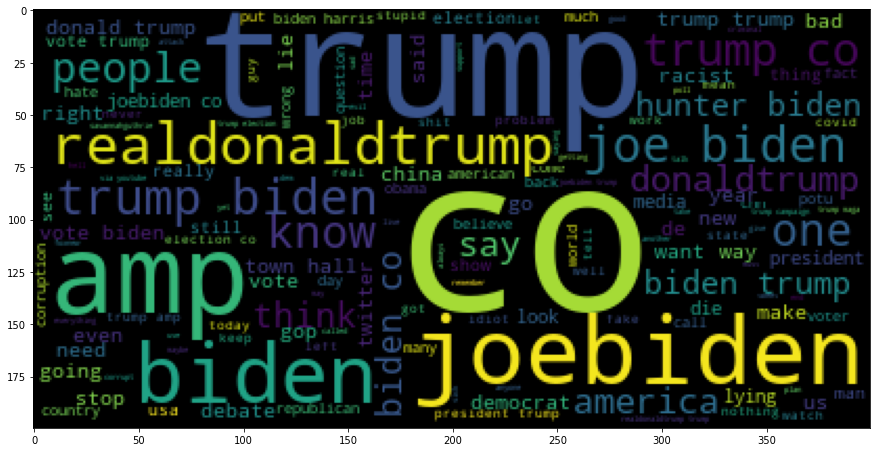

In [36]:
df_negativas = dataset.loc[dataset['sentiment'] == 'negative']
negativas = " ".join(df_negativas['texto_sem_stopwords'])
cria_nuvem_palavras(negativas)